## Picture Demo

In [1]:
import os
import re
import sys

import cv2
import math
import time
import scipy
import argparse
import matplotlib
import numpy as np
import pylab as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from scipy.ndimage.filters import gaussian_filter

import matplotlib
%matplotlib inline
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from network.fastpose import get_model
from training.datasets.coco_data.preprocessing import (inception_preprocess,
                                              rtpose_preprocess,
                                              ssd_preprocess, vgg_preprocess)
from network import im_transform
from evaluate.coco_eval import get_multiplier, get_outputs_test, handle_paf_and_heat_test
import evaluate.coco_eval

import network.post
import demo.utils_eval 
import network.post


os.environ["CUDA_VISIBLE_DEVICES"] = '6'

In [2]:
color = []
for i in range(0,255,80):
    for j in range(0,255,80):
        for k in range(0,255,80):
            color.append((i,j,k))
coco_ann = { 'nose':0, 'neck':1, 'right_shoulder' :2, 'right_elbow' :3, 'right_wrist':4, 
             'left_shoulder':5, 'left_elbow':6, 'left_wrist':7, 'right_hip':8, 
             'right_knee':9, 'right_ankle':10, 'left_hip':11, 'left_knee':12, 
             'left_ankle':13, 'right_eye':14, 'left_eye':15, 'right_ear':16, 
             'left_ear':17 }
coco_ann_r = dict(zip(coco_ann.values(), coco_ann.keys()))
coco_middle = {'nose--left_eye':0,'nose--right_eye':1,'left_eye--left_ear':2,'right_eye--right_ear':3,
               'nose--neck':5,'left_shoulder--left_elbow':6,
               'right_shoulder--right_elbow':7,'left_elbow--left_wrist':8,'right_elbow--right_wrist':9,
               'left_hip--right_hip':10,'left_shoulder--left_hip':11,'right_shoulder--right_hip':12,
               'left_hip--left_knee':13,'right_hip--right_knee':14,'left_knee--left_ankle':15,'right_knee--right_ankle':16,
               'neck--left_shoulder':4,'neck--right_shoulder':17,
               'background':18}
coco_middle_r = dict(zip(coco_middle.values(), coco_middle.keys()))

def persons_jointForm(persons):
    persons_forJoint = []
    for person_idx in range(len(persons)):
        pj = [[] for i in range(18)]
        for point_idx in range(len(persons[person_idx])):
            pj[int(persons[person_idx][point_idx][4])] = persons[person_idx][point_idx]
        persons_forJoint.append(pj)
    return persons_forJoint

### Load Model

In [3]:
weight_name = './network/weights/fastpose.pth'

model = get_model('vgg19')     
# model.load_state_dict(torch.load(weight_name))
old_state_dict = torch.load(weight_name, map_location=lambda storage, loc: storage)
new_state_dict = OrderedDict()
for k, v in old_state_dict.items():
    new_state_dict[k[7:]] = v
model_dict = model.state_dict()
model_dict.update(new_state_dict)
model.load_state_dict(model_dict)

model.cuda()
model.float()
model.eval()

Bulding VGG19


rtpose_model(
  (model0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(i

### Network forward

In [4]:
# test_image = './readme/ski.jpg'
# test_image = './readme/hiking.png'
test_image = './readme/superman.jpg'


oriImg = cv2.imread(test_image) # B,G,R order
shape_dst = np.min(oriImg.shape[0:2])

# Get results of original image
multiplier = get_multiplier(oriImg)

with torch.no_grad():
    orig_heat = evaluate.coco_eval.get_outputs_test(
        multiplier, oriImg, model,  'rtpose')
          
    # Get results of flipped image
    swapped_img = oriImg[:, ::-1, :]
    flipped_heat = evaluate.coco_eval.get_outputs_test(multiplier, swapped_img,
                                            model, 'rtpose')

    # compute averaged heatmap and paf
    heatmap = handle_paf_and_heat_test(
        orig_heat, flipped_heat)
            
param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}



### Grouping

In [5]:
joint_list, middle_joint_list = network.post.decode_pose_test(oriImg, param, heatmap, [])
jl,mjl = network.post.outputChangeForm_test(joint_list.tolist())
persons,pair,persons_withMiddlePoint,jointLength,peaks_1,peaks_2,_ = demo.utils_eval.person_group_test(jl,mjl,distance_tolerance=0.2)
persons_forJoint = persons_jointForm(persons)

### Visualization

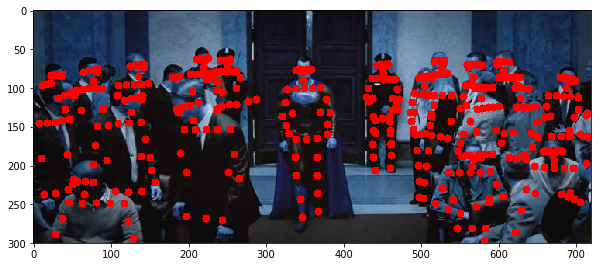

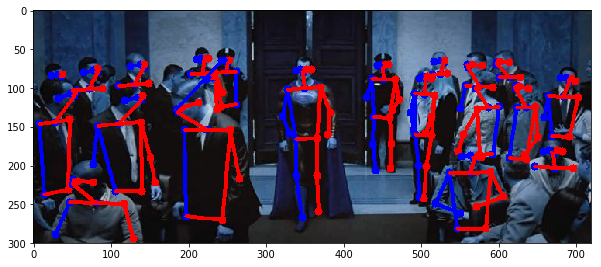

True

In [6]:

person_picture = persons_forJoint
canvas = oriImg.copy()
plt.figure(figsize=(10,10))
for joint_indices in range(len(joint_list)):
    cv2.circle(canvas, (int(joint_list[joint_indices, 0]),int(joint_list[joint_indices, 1])), 5, (255,0,0), thickness=-1)
for joint_indices in range(len(middle_joint_list)):
    cv2.circle(canvas, (int(middle_joint_list[joint_indices, 0]),int(middle_joint_list[joint_indices, 1])), 3, (255,0,0), thickness=-1)
plt.imshow(canvas)
plt.show()
plt.close() 

plt.figure(figsize=(10,10))
canvas = oriImg.copy()
for person_idx in range(len(person_picture)):
    if len(persons[person_idx])<=3:
        continue
    for point_idx in range(len(person_picture[person_idx])):
        if len(person_picture[person_idx][point_idx])==0:#int(person_picture[person_idx][point_idx][0])>260:
            continue
        if int(person_picture[person_idx][point_idx][4]) in [5,6,7,11,12,13,15,17]:#left
            cv2.circle(canvas, (int(person_picture[person_idx][point_idx][0]),int(person_picture[person_idx][point_idx][1])), 5, (255,0,0), thickness=-1)
        else:
            cv2.circle(canvas, (int(person_picture[person_idx][point_idx][0]),int(person_picture[person_idx][point_idx][1])), 5, (0,0,255), thickness=-1)            

    for key in coco_middle:
        jl = (key.split('--'))
        if len(jl)==2:
            pt1=person_picture[person_idx][ coco_ann[jl[0]] ]
            pt2=person_picture[person_idx][ coco_ann[jl[1]] ]
            if len(pt1)==0 or len(pt2)==0:
                continue
            if int(pt1[4]) in [2,3,4,8,9,10,14,16] and int(pt2[4]) in [2,3,4,8,9,10,14,16]:#right blue 
                    cv2.line(canvas,(int(pt1[0]),int(pt1[1])),(int(pt2[0]),int(pt2[1])),(0,0,255),3 )
            else:
                cv2.line(canvas,(int(pt1[0]),int(pt1[1])),(int(pt2[0]),int(pt2[1])),(255,0,0),3 )
plt.imshow(canvas)
plt.show()
plt.close()
cv2.imwrite('result.png',canvas)
